# Template matching for georeferencing improvement

We use a template matching technique that uses sentinel data to match the found water area and correct the geolocation. 

There are a number of limitations to this approach:
- there needs to be water present in the area
- the surrounding area has to be low in high vegatation
- ...

Steps

1. load a classified raster
1. run google earth engine script 
1. match water in both classifications
1. if correction is lower than or around 8 meters accept the result
1. write corrected geojson to file

In [33]:
# define helper functions
import fiona
import glob

from shapely.ops import cascaded_union, unary_union
from shapely.geometry import shape, Point

In [34]:
def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
            
    return shape_list

def check_valid_geometries(shapefile_path):
    
    shape_list = []
    
    if fiona.open(shapefile_path).crs['init'] != 'epsg:4326':
        print('crs is not epsg:4326, skipping...')
        
        crs_check = False
    else:
        crs_check = True
        
        

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
            
    return shape_list, crs_check

# GEE getThumbUrl example

In [2]:
# import libaries

# Import the Earth Engine Python Package
import ee

try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *
from skimage import io

import cv2 as cv

     
# scikit-image modules for image science operators
from skimage import filters, morphology

import rasterio 
import glob

from pprint import pprint

from shapely.ops import cascaded_union

# load classification data from file

In [729]:
# find files in classification folders
raster_files_path = '../../data/nir_green_blue/classifications/*.tif'
raster_files = glob.glob(raster_files_path)
file_path = raster_files[302]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files[0:5])
print('-------------------------------------')
print(file_path)
print('-------------------------------------')

520
-------------------------------------
['../../data/nir_green_blue/classifications/Jakarta_180_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif',
 '../../data/nir_green_blue/classifications/Jakarta_123_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif',
 '../../data/nir_green_blue/classifications/Medan_296_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif',
 '../../data/nir_green_blue/classifications/Jakarta_002_pansharpen_False_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif',
 '../../data/nir_green_blue/classifications/Medan_314_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif']
-------------------------------------
../../data/nir_green_blue/classifications/Jakarta_126_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
-------------------------------------


In [730]:
# load data
data = rasterio.open(file_path).read()
dataset = rasterio.open(file_path)

affine = dataset.meta['transform']
width = dataset.meta['width']
height = dataset.meta['height']

x_min, y_min, x_max, y_max = dataset.bounds

dataset_crs = dataset.meta['crs'].to_epsg()

if dataset_crs == 4326:
    print('crs check passed (epsg:4326)')
else:
    print('crs error! please check input data, make sure crs matches epsg:4326')

crs check passed (epsg:4326)


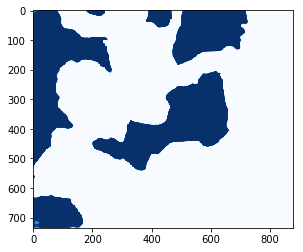

In [731]:
# quick visual inspection
plt.imshow(data[0], cmap = 'Blues')

In [732]:
# set variables
SCALE = 1;
polarization = 'VV'; # vertical/vertical or vertical/horizontal

# SAR data (Google Earth Engine)

In [733]:
# fix bbox for gee
x_min_SAR = x_min - 0.0015
x_max_SAR = x_max + 0.0015
y_min_SAR = y_min - 0.0015
y_max_SAR = y_max + 0.0015

rect_list = [[x_min_SAR,y_min_SAR],
            [x_max_SAR,y_min_SAR],
            [x_max_SAR,y_max_SAR],
            [x_min_SAR,y_max_SAR],
            [x_min_SAR,y_min_SAR]]

# build geometry to measure
rect = ee.Geometry.Polygon(rect_list)
# convert geometry to JSON format
rect_JSON = rect.getInfo()['coordinates']

In [734]:
rect_JSON[0]

[[106.61621872897234, -6.34656259853755],
 [106.6234747566403, -6.34656259853755],
 [106.6234747566403, -6.340003804071147],
 [106.61621872897234, -6.340003804071147],
 [106.61621872897234, -6.34656259853755]]

In [735]:
from shapely.geometry import Polygon
extend_SAR = Polygon([(point[0],point[1]) for point in rect_JSON[0]])

In [736]:
# initiate google earth engine to aquire the image
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterDate('2016-01-01', '2019-12-12')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.select(polarization)\
.filterBounds(rect);

In [737]:
def maskEdge(img):
    mask = img.select(0).unitScale(-25, 5).multiply(255).toByte().connectedComponents(ee.Kernel.rectangle(1,1), 100);
    return img.updateMask(mask.select(0)); 

def reproj(layer):
    layer = layer.reproject(crs ='EPSG:4326', scale = SCALE); 
    return layer;

# Get the VV collection.
Collection = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filterDate('2019-01-01', '2020-09-30')

Collection = Collection.map(maskEdge);

VH = Collection.select(['VH']).reduce(ee.Reducer.percentile([60])).clip(rect)
VV = Collection.select(['VV']).reduce(ee.Reducer.percentile([10])).clip(rect)

VH = reproj(VH)
total = VH.add(VV).divide(2)
total = reproj(total);



In [738]:
# total_metadata = total.getInfo()

In [739]:
# total_metadata

In [740]:
# visualize resulting image
url = total.getThumbUrl({
    'region':rect_JSON,
    'min':-20,
    'max':-5,
    'palette':['0784b5', '39ace7', '9bd4e4', 'cadeef', 'ffffff']
})

In [741]:
url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/676eacc345381032b8015372b781474b-301aa40955a018b7a0482e6059abfd8b:getPixels'

In [742]:
# Download tumbnail
SAR_img = io.imread(url)

In [743]:
d_y = (y_max_SAR - y_min_SAR)

d_x = (x_max_SAR - x_min_SAR)

In [744]:
d_x

0.007256027667963849

In [745]:
deg_pix_x_SAR = d_x / SAR_img.shape[1]

deg_pix_y_SAR = d_y / SAR_img.shape[0]

In [746]:
deg_pix_x_SAR

8.980232262331496e-06

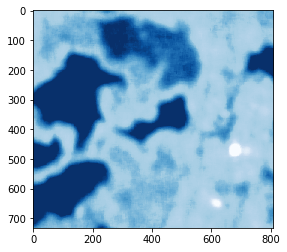

In [747]:
array_SAR_img = SAR_img[:,:,1]
plt.imshow(array_SAR_img *-1, cmap = 'Blues', )

In [748]:
affine

Affine(4.841897233201582e-06, 0.0, 106.61771872897233,
       0.0, -4.841897233201582e-06, -6.341503804071147)

In [749]:
x_pix_size, row_rotation, x_orig, col_rotation, y_pix_size, y_orig, g, h, i = affine[:]

In [750]:
y_min_raster = y_orig - (y_pix_size * height)

In [751]:
y_min_raster

-6.337945009604744

In [752]:
height, width

(735, 879)

In [753]:
# get bands or get classification depending on what is available

if data.shape[0] == 8:
    coastal = data[0,:,:].astype(np.float32)
    nir1 = data[6,:,:].astype(np.float32)
    nir2 = data[7,:,:].astype(np.float32)
    red = data[4,:,:].astype(np.float32)


    # perform index calculations 
    avg = (nir1+nir2)/2
    ndwi_WV = (coastal - avg)/(coastal + avg)
    ndvi = (nir1 - red)/(nir1 +red)
    wwi = (coastal - nir2) / (coastal + nir2 + 10e-5)
    
else: 
    
    ndwi_WV = data[0]

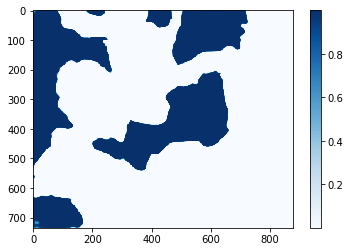

In [754]:
plt.imshow(ndwi_WV, cmap = 'Blues');plt.colorbar()

In [755]:
try:
    array_ndwi_WV = wii.compute()
except:
    array_ndwi_WV = ndwi_WV

In [756]:
OldRange = (array_ndwi_WV.max() - array_ndwi_WV.min())  
NewRange = (255)  
NewValue = (((array_ndwi_WV - array_ndwi_WV.min()) * NewRange) / OldRange) + 0

In [757]:
array_ndwi_WV_int_base = NewValue.round().astype(uint8)

array_ndwi_WV_int_base

array([[ 23,  23,  11, ...,   0,   0,   4],
       [ 23,  23,  11, ...,   0,   0,   4],
       [ 10,  10,   7, ...,   0,   0,   1],
       ...,
       [162, 162, 216, ...,   0,   0,   0],
       [109, 109, 151, ...,   0,   0,   1],
       [ 79,  79,  88, ...,   0,   0,   7]], dtype=uint8)

In [758]:


# apply guassian blur on src image
# array_ndwi_WV_int = cv.GaussianBlur(array_ndwi_WV_int,(5,5),100) # (501,501),cv.BORDER_DEFAULT)

array_ndwi_WV_int = cv.medianBlur(array_ndwi_WV_int_base,1) 

array_ndwi_WV_int # = array_ndwi_WV_int_base

array([[ 23,  23,  11, ...,   0,   0,   4],
       [ 23,  23,  11, ...,   0,   0,   4],
       [ 10,  10,   7, ...,   0,   0,   1],
       ...,
       [162, 162, 216, ...,   0,   0,   0],
       [109, 109, 151, ...,   0,   0,   1],
       [ 79,  79,  88, ...,   0,   0,   7]], dtype=uint8)

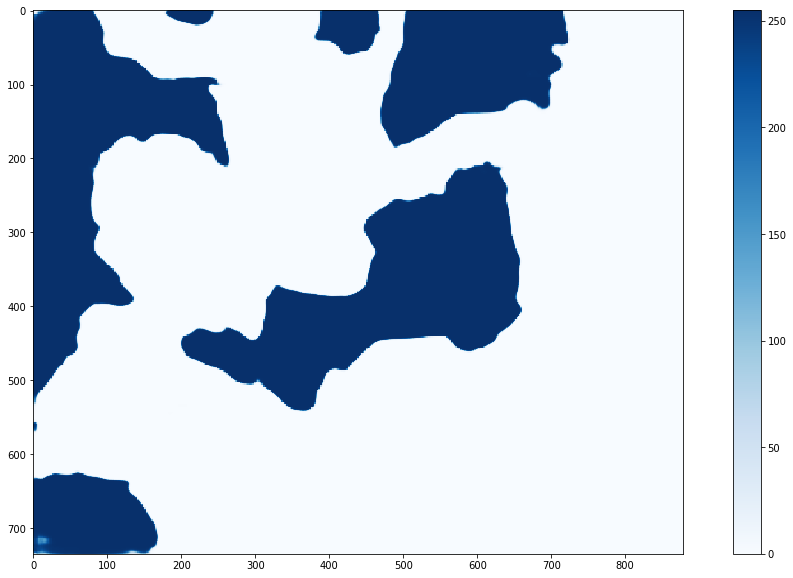

In [759]:
fig, ax = subplots(figsize=(18, 10))
ec = ax.imshow(array_ndwi_WV_int, cmap='Blues')
cbar = plt.colorbar(ec)
# cbar.set_label('values')


(-0.5, 807.5, 731.5, -0.5)

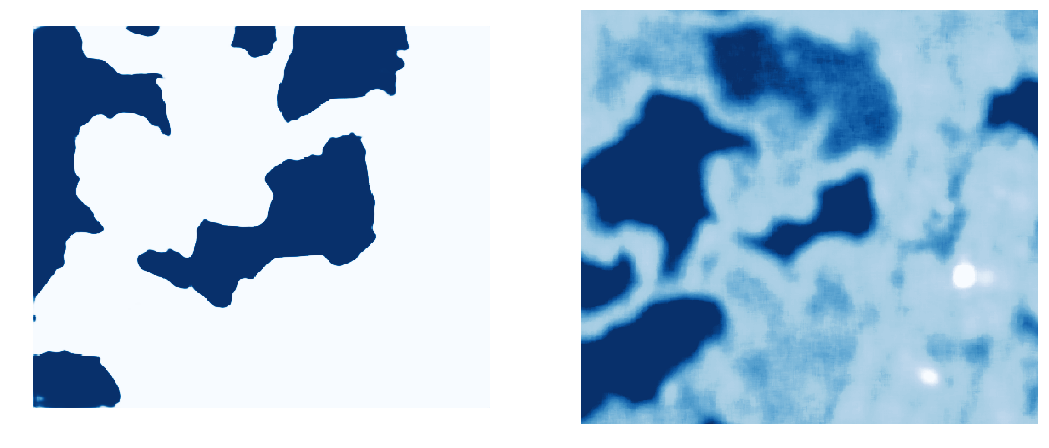

In [760]:
fig, ax = subplots(1,2, figsize=(18, 10));

ax[0].imshow(array_ndwi_WV_int, cmap = 'Blues'); ax[0].axis('off')
# ax[0].set_title('WorldView')

ax[1].imshow(array_SAR_img * -1, cmap = 'Blues'); ax[1].axis('off')
# ax[1].set_title('SAR')

In [761]:
array_SAR_img.shape ,array_ndwi_WV_int.shape

((732, 808), (735, 879))

In [762]:
imgshowx_s_WV = array_ndwi_WV_int.shape[1]

x_s_WV

696

In [763]:
d_x_WV = x_max - x_min

deg_pix_WV = x_pix_size # d_x_WV / x_s_WV 

devide_WV =  deg_pix_WV / deg_pix_x_SAR

In [764]:
deg_pix_WV, deg_pix_x_SAR

(4.841897233201582e-06, 8.980232262331496e-06)

In [765]:
thresh = filters.threshold_otsu(array_ndwi_WV_int)
array_ndwi_WV_int = array_ndwi_WV_int > thresh

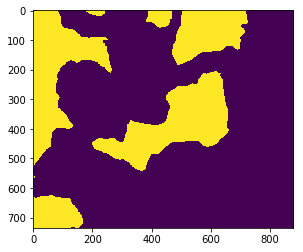

In [766]:
plt.imshow(array_ndwi_WV_int)

In [767]:
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 100.

# From the image metadata, we can determine the area of a single grid cell
try: 
    cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
except: 
    cell_height_m = 0.40
    
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')


# First, remove the small holes
water_cleaned = morphology.remove_small_holes(array_ndwi_WV_int.astype(int), min_feature_size_cells  )

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

100.0 sq. m
625 grid cells


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


In [768]:
array_ndwi_WV_int = water_cleaned

In [769]:
# array_SAR_img[array_SAR_img > 220] = 220

In [770]:
array_SAR_img = SAR_img[:,:,1]

In [771]:
array_SAR_img = SAR_img[:,:,1]

thresh = filters.threshold_otsu(array_SAR_img)

array_SAR_img = array_SAR_img < thresh

Text(0.5, 1.0, 'SAR')

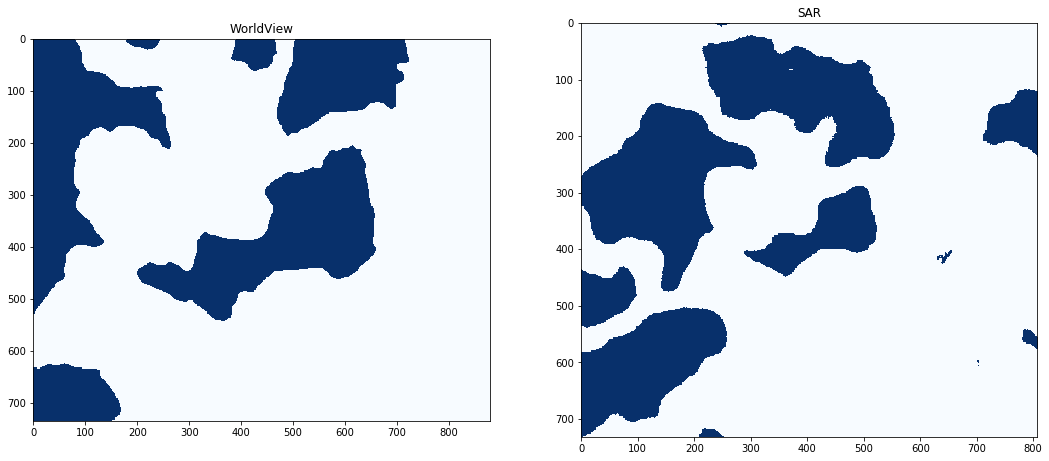

In [772]:
imgshowfig, ax = subplots(1,2, figsize=(18, 10));

ax[0].imshow(array_ndwi_WV_int, cmap = 'Blues'); 
ax[0].set_title('WorldView')

ax[1].imshow(array_SAR_img, cmap = 'Blues'); 
ax[1].set_title('SAR')
# array_ndwi_WV_int[array_ndwi_WV_int > 18b

# plt.colorbar()
# plt.colorbar()

In [773]:
array_SAR_img.shape

(732, 808)

In [774]:
array_ndwi_WV_int.shape

(735, 879)

In [775]:
array_ndwi_WV_int = array_ndwi_WV_int.astype('uint8')

In [776]:
# get ratios

x = int(round(array_ndwi_WV_int.shape[0] * devide_WV, 0 ))

y = int(round(array_ndwi_WV_int.shape[1] * devide_WV, 0 ))

In [777]:
x

396

In [778]:
y

474

In [779]:
array_ndwi_WV_int_match = cv.resize(array_ndwi_WV_int, dsize=(y, x), interpolation=cv.INTER_CUBIC)

In [780]:
array_ndwi_WV_int_match = array_ndwi_WV_int_match.astype('uint8')

array_SAR_img = array_SAR_img.astype('uint8')

# Template matching


In [781]:
array_SAR_img.dtype

dtype('uint8')

In [782]:
import numpy as np

search_image = array_SAR_img
template = array_ndwi_WV_int_match

from PIL import Image

width, height = template.shape[::-1] #get the width and height

match = cv.matchTemplate(search_image, template, cv.TM_CCOEFF_NORMED)
max_value = match.max()
position = np.where(match == max_value)

In [783]:
template.shape[::-1]

(474, 396)

In [784]:
search_image.shape[::-1]

(808, 732)

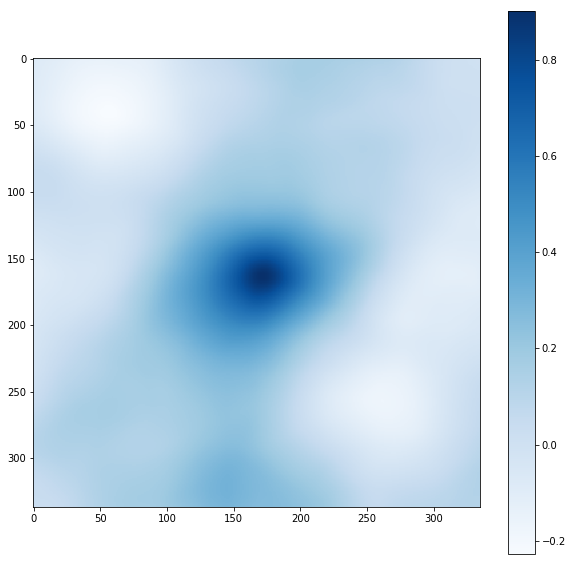

In [803]:
plt.figure(figsize= (10,10))
plt.imshow(match, cmap = "Blues",);plt.colorbar()

In [786]:
position

(array([164]), array([171]))

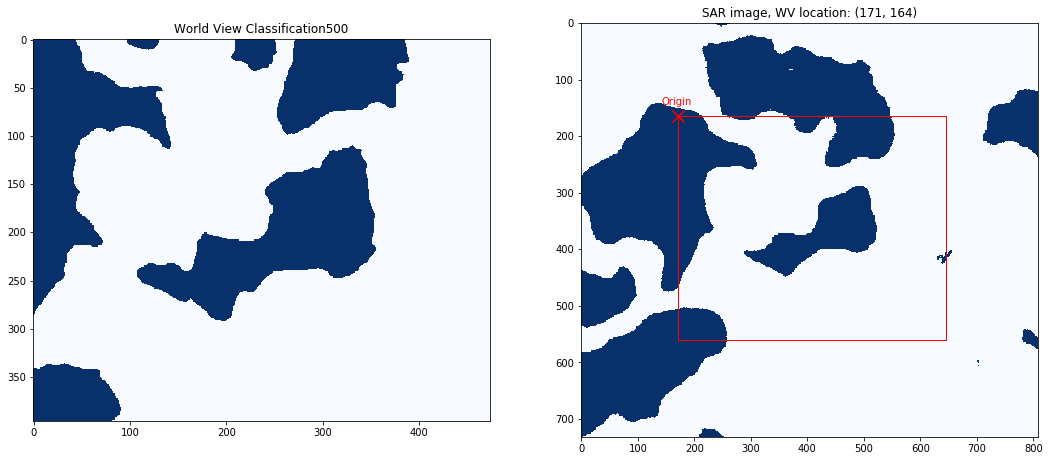

In [787]:
fig, ax = subplots(1,2,figsize=(18, 10))

ax[0].imshow(array_ndwi_WV_int_match, cmap = 'Blues')
ax[0].set_title("World View Classification500")
ax[1].imshow(array_SAR_img, cmap = 'Blues')
ax[1].scatter(position[1],position[0], s=150, c='red', marker='x')
ax[1].text(position[1]-30,position[0]-20, 'Origin', color='r')

         
# Create a Rectangle patch
rect = matplotlib.patches.Rectangle((position[1],position[0]),width,height,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax[1].add_patch(rect)

ax[1].set_title('SAR image, WV location: {}'.format((int(position[1]),int(position[0]))))

plt.show()

In [788]:
(position[1] * deg_pix_x_SAR)+ x_min_SAR

array([106.61775435])

In [789]:
x_SAR = float((position[1] * deg_pix_x_SAR) + x_min_SAR)

y_SAR = float((position[0] * deg_pix_y_SAR * -1) + y_max_SAR)

In [790]:
deg_pix_y_SAR

8.960101730058677e-06

In [791]:
x_offset = x_SAR - x_orig
y_offset = y_SAR - y_orig

In [792]:
x_min

106.61771872897233

In [793]:
x_SAR, y_SAR, x_orig, y_orig

(106.6177543486892, -6.341473260754876, 106.61771872897233, -6.341503804071147)

In [805]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(y_SAR)
lon1 = radians(x_SAR)
lat2 = radians(y_orig)
lon2 = radians(x_orig)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c
distance_m = round(distance * 1000, 2)

print('offset: ', distance_m , 'm')

if distance_m > 8:
    print('error, offset to large, keep current location')

offset:  5.2 m


In [795]:
print('x_offset = ', x_offset)
print('y_offset = ', y_offset)

x_offset =  3.561971686849574e-05
y_offset =  3.054331627083684e-05


In [796]:
sqrt(x_offset**2 + y_offset**2)

4.692183285648768e-05

In [797]:
from shapely.geometry import Point, shape

In [798]:
point_origin = Point([y_SAR, x_SAR])

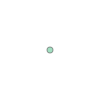

In [799]:
point_origin

In [800]:
import folium

m = folium.Map([point_origin.x, point_origin.y],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB',
              max_zoom=30)

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)

# folium.Choropleth(setu_wgs, name = 'Setu water delineation').add_to(m)

folium.Choropleth(extend_SAR, name = 'extend_SAR').add_to(m)

folium.Marker([y_SAR, x_SAR], popup='origin SAR').add_to(m)
folium.Marker([y_orig, x_orig], popup='origin WV').add_to(m)

folium.LayerControl().add_to(m)

In [801]:
m

## Plot image to geotiff with costum reference

In [216]:
xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
nrows,ncols = np.shape(array)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0, -yres)   
# That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
#         top left y, rotation (0 if North is up), n-s pixel resolution)
# I don't know why rotation is in twice???

output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
                                             # Anyone know how to specify the 
                                             # IAU2000:49900 Mars encoding?
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
                                                   # to the file
output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster

output_raster.FlushCache()

NameError: name 'lon' is not defined

# Save as image file

In [439]:
# save one image
import matplotlib.pyplot as plt
import datetime
NOW = datetime.datetime.now()


fig, ax = plt.subplots(1,figsize=(100,100))
plt.imshow(match, cmap = "jet")#, vmin=-1, vmax=1,) # edit this to plot another raster
fig.savefig('Template_matching_setu_babakan_{}.png'.format(NOW),
            bbox_inches='tight')
plt.close(fig)    # close the figure

# Resize array using PIL (cv resize used)

In [46]:
from PIL import Image

# Convert array to Image
array_water_index_int_PIL = Image.fromarray(array_water_index_int)

array_water_index_int_PIL_match = array_water_index_int_PIL.resize((array_SAR_img.shape[1],array_SAR_img.shape[0]))

#img1 = np.array(array_water_index_int_PIL_match).astype(uint8)

array_water_index_int_PIL_match

In [344]:
import random

In [356]:
np.random.choice(55, 1)

array([17])

In [ ]:
# Jakarta: 281, 299
# Medan: 225, 194
# denpasar: 6 , 16

# match features (no success)

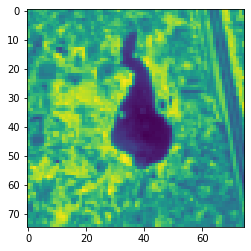

In [899]:


img1 = array_SAR_img
img2 = array_ndwi_WV_int_match

plt.imshow(img2)


In [900]:


# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)

kp2, des2 = orb.detectAndCompute(img2,None)

In [901]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:100],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

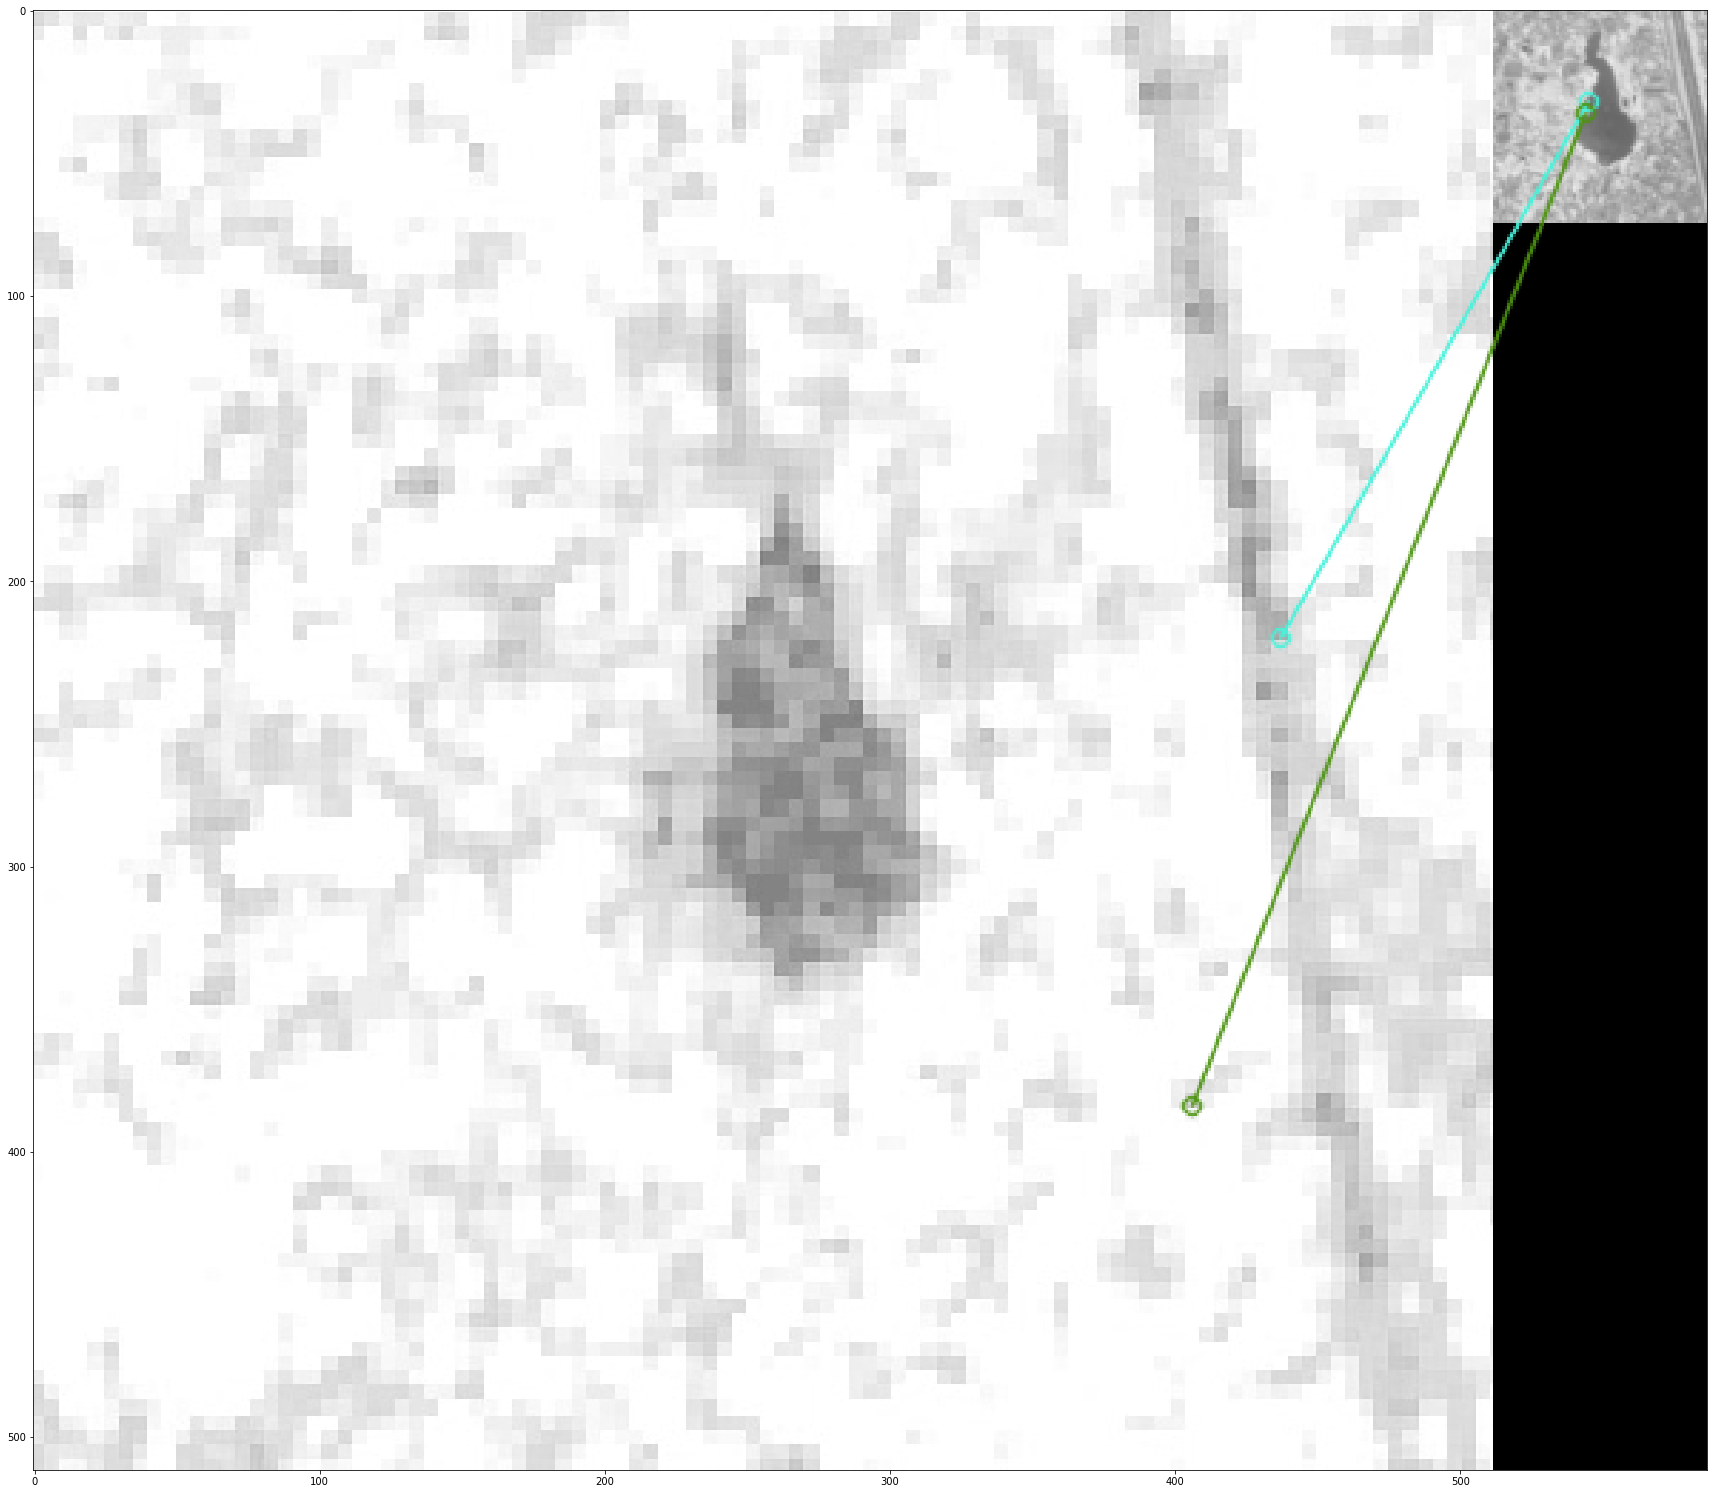

(<matplotlib.image.AxesImage at 0x7f39d18a8390>, None)

In [902]:

fig, ax = subplots(figsize=(30, 30))
ax.imshow(img3),plt.show()